# Exercise 06
## 1 Bias and variance of ridge regression 

$$\hat \beta = \text{arg}\underset{\beta}{\text{min}}\ \underbrace{||X\beta -y||_2^2+\tau\ ||\beta||_2^2}_{=:B}$$
We will now take the derivative of $B$ with respect to $\beta$ in order to find $\hat \beta$.
$$0\overset{!}{=}\frac{\partial B}{\partial \beta}=
\frac \partial{\partial \beta} \left( ||X\beta-y||^2\right)+\frac \partial{\partial \beta}\left( \tau ||\beta||^2\right)
=2X^\intercal\ \left( X\beta-y\right)+2\tau \beta\\
\Rightarrow X^\intercal y=\left(X^\intercal X+\tau \mathbb{1} \right)\beta\\
\Rightarrow \hat \beta = \left( X^\intercal X+\tau \mathbb{1} \right)^{-1} X^\intercal y = S_{\tau}^{-1} \left( S \beta^*+X^\intercal\epsilon\right)
$$
Now we calculate the expectation value:
$$\mathbb{E}[\hat \beta]=\underbrace{\mathbb E [S_{\tau}^{-1}S\beta^*]}_{S_{\tau}^{-1}S\beta^*}+ \underbrace{\mathbb E [S_{\tau}^{-1}X^\intercal\epsilon]}_{0}=S_{\tau}^{-1}S\beta^*$$

## 2 Denoising of a CT image

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sLA
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
def construct_X(M, alphas, Np = None, tau = 0):
    '''
    M: resulting tomogram size D in one dimension (D=MxM) 
    alphas: list of No angles in degrees
    Np: sensor resolution (optional)
    tau: regularization parameter 
    returns X of shape (Np*No)xD or (Np*No+D)xD if tau is greater than 0
    '''
    #check if tau is not negative:
    if tau<0:
        raise ValueError('tau is negative')
    #convert to numpy array and into radian
    alphas=np.array(alphas)*np.pi/180
    #in case Np is not given we will select one large enough to fit the diagonal of the image beta
    if Np==None:
        Np=np.ceil(np.sqrt(2)*M)
        if Np%2==0: #Np is even
            Np+=1
    
    N=len(alphas)*Np #response vector size
    D=M*M
    #create coordinate matrix C of the ceter of each pixel measured from the center of the image
    
    #"x" distance
    C_0 = np.mod(np.arange(D),M) - (M - 1)/2
    #"y" distance
    C_1 = np.floor_divide(np.arange(D),M) - (M - 1)/2
    #merge for C
    C = np.array([C_0,C_1]).T
    #project the C vector onto the sensor array direction
    translation = C@np.array([np.cos(alphas),np.sin(-alphas)])
    #this is now projected on the senor using the position of the center as reference
    sensorpos = (Np - 1)/ 2 + translation.T
    #first the indices of the smaller pixels then the ones of the larger ones
    i_p = np.array([np.floor(sensorpos), np.ceil(sensorpos)]).flatten()
    #[0]*D,[1]*D,...,[No-1]*D twice repeated
    i_o = np.tile(np.outer(np.arange(len(alphas)),np.ones(D)).flatten(),2)
    #combine them to our i_indices
    i_indices =  i_p + Np * i_o
    
    #simply [0,1,...,No-1]*2D
    j_indices = np.tile(np.tile(np.arange(D),len(alphas)),2)
    
    #compute the weights
    weight_ceil = np.mod(sensorpos, 1).flatten()
    weight_floor = 1 - weight_ceil
    #and combine them in the correct order
    weights = np.append(weight_floor,weight_ceil)
    
    #now we build the matrix X:
    X = sp.coo_matrix((weights, (i_indices, j_indices)),shape = (N,D), dtype = np.float32)
    #if tau=0 we return the X matrix...
    if tau==0:
        return X
    elif tau>0:
        #... if not we return the augmented version X'
        return sp.vstack([X,np.sqrt(tau)*sp.identity(D,format='coo')])
        

In [67]:
def compute_mu(X,y):
    '''
    X: weight matrix of shape (N,D)
    y: sensor data
    returns the image 
    '''
    #use scipy.sparse.linalg.lsqr to calculate beta, also convert X to Compressed Sparse Column format 
    beta=sLA.lsqr(sp.csc_matrix(X),y,atol=1e-5,btol=1e-5)[0]
    #get M from D
    M=int(np.sqrt(len(beta)))
    #return the image mu by reshaping beta
    return beta.reshape(M,M)

In [68]:
alphas = np.load('hs_tomography/alphas_195.npy')
y = np.load('hs_tomography/y_195.npy')

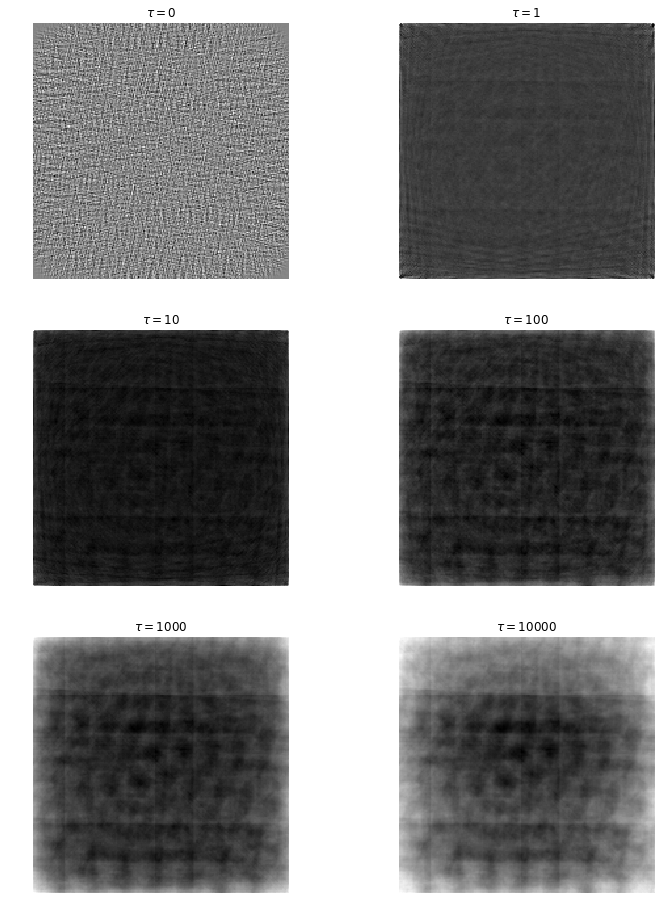

In [69]:
fig=plt.figure(figsize=(12,16))
M,Np,No=195,275,64
#regularization parameter at each step
taus=[0, 1, 10, 100, 1000, 10000]
#64 angels:
angels=alphas[[int(np.ceil(len(alphas) * p/No)) for p in range(No)]]
ys=y[[int(np.ceil(len(y) * p/(No*Np))) for p in range(Np*No)]]
#if tau is not 0 we need to add D zeros
ytau=np.append(ys,np.zeros(M**2))

for i in range(len(taus)):
    fig.add_subplot(int(len(taus)/2),2,1+i)
    plt.gray()
    #select the correct y
    yi=ys if taus[i]==0 else ytau
    plt.imshow(compute_mu(construct_X(M,angels,Np,taus[i]),yi))
    plt.title(r'$\tau= %i$'%(taus[i]))
    plt.axis('off')